The goal of this notebook is to produce initial results for Milestone 4.

My plan is to try to classify organic compounds from chemical entities, using binned mz's.

In [1]:
# User-defined modules
import os, sys
src_dir = os.path.normpath('../util')
sys.path.insert(0, src_dir)
import util

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import fisher_exact
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, confusion_matrix, auc

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/claire/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Read in the csv data
fname = '../../data/clean/metabolites_and_spectra.csv'
all_mtabs = util.unpackCSV(fname)

In [4]:
# Make tidy dataframe with [inchi, hmdb_id, all-taxonomy-levels, ms2_id, npeaks, ionization]
taxa_cols = ['kingdom', 'super_class', 'sub_class', 'class', 'molecular_framework']
empty_tax_dict = {i: '' for i in taxa_cols}
dflst = []
for m in all_mtabs:
    mtab = all_mtabs[m]
    n_ms2 = len(mtab.MS2)
    if n_ms2 > 0:
        hmdb_id = mtab.accession
        
        # Get taxonomy info, or if it doesn't have any make it empty
        taxonomy = mtab.taxonomy_dict
        if taxonomy is None:
            taxonomy = empty_tax_dict

        # Set up the molecule metadata
        m_lst = [m, hmdb_id] + [taxonomy[t] for t in taxa_cols]
        
        # Get all of the MS2 peaks
        for i in range(n_ms2):
            peaks = mtab.MS2[i].peaks
            
            if peaks is not None:
                npeaks = len(peaks)
                # Assemble list of [mlcl_metadata, ms2_scan, peak1, int1]
                dflst += [m_lst + [i, npeaks, p[0], p[1], mtab.MS2[i].ionization_mode] for p in peaks]
        

In [5]:
cols = ['inchi', 'hmdb'] + taxa_cols + ['ms2_scan', 'num_peaks', 'mz', 'intensity', 'ion_mode']
dfpeaks = pd.DataFrame(dflst, columns=cols)
dfpeaks = dfpeaks.rename(columns={'class': 'cls'})
dfpeaks.head(15)

,inchi,hmdb,kingdom,super_class,sub_class,cls,molecular_framework,ms2_scan,num_peaks,mz,intensity,ion_mode
0,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,0,1,254.889000,100.000000,Positive
1,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,136.870000,34.965000,Positive
2,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,180.910000,26.628000,Positive
3,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,198.460000,8.300000,Positive
4,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,198.870000,45.266000,Positive
5,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,254.860000,100.000000,Positive
6,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,2,4,65.060000,39.174000,Positive
7,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,2,4,90.990000,100.000000,Positive
8,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,2,4,136.860000,13.277000,Positive
9,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,2,4,152.410000,8.384000,Positive


In [7]:
dfpeaks['mz'].max()

1980.289

In [8]:
dfpeaks['mz'].min()

0.0114

In [9]:
# How many unique Positive-mode molecules do we have?
dfpeaks.query('ion_mode == "Positive"')['inchi'].unique().shape

(729,)

# Binning mz's

Many options:   

- just round to the nearest unit   
- bin based on distribution (i.e. make 1000 bins, where each bin has the same number of masses)   
- bin based on informative-ness (like the barcoding paper, would need to be creative to determine "informativeness"...)

Let's do the first one first: round each mz to the nearest unit.

Next step: bin each unique mz so that each bin has the same number of unique mz's (not total number of fragments)

In [6]:
# Just round down by converting float to int
dfpeaks['rounded_mz'] = dfpeaks['mz'].astype(int)
dfpeaks.head()

,inchi,hmdb,kingdom,super_class,sub_class,cls,molecular_framework,ms2_scan,num_peaks,mz,intensity,ion_mode,rounded_mz
0,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,0,1,254.889,100.000,Positive,254
1,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,136.870,34.965,Positive,136
2,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,180.910,26.628,Positive,180
3,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,198.460,8.300,Positive,198
4,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,5,198.870,45.266,Positive,198


In [7]:
# Need to drop inchi-rounded_mz duplicates for the pivot.
# Note that here, I am merging all MS2's from the same inchi molecule.
binarypeaks = dfpeaks\
    [['inchi', 'rounded_mz']].drop_duplicates()\
    .pivot(index='inchi', columns='rounded_mz', values='rounded_mz')\
    .notnull()\
    .astype(int)

In [8]:
binarypeaks.head()

rounded_mz,0,1,3,4,6,7,8,9,10,11,...,1877,1882,1885,1890,1904,1905,1933,1948,1961,1980
inchi,,,,,,,,,,,,,,,,,,,,,
ACFIXJIJDZMPPO-NCHANQSKSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACWBBAGYTKWBCD-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AEMFNILZOJDQLW-QAGGRKNESA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AEMOLEFTQBMNLQ-DTEWXJGMSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AEMOLEFTQBMNLQ-WAXACMCWSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Classify kingdom

In [9]:
def make_XY(binarypeaks, dfpeaks):
    """
    Make the X and Y arrays for classification.
    
    Y has kingdom-level labels: "Chemical entities" are 0 and 1 otherwise,
    in same order as in X.
    
    binarypeaks has inchi keys in index
    dfpeaks has ['inchi', 'kingdom'] columns
    """
    XandY = pd.merge(binarypeaks, dfpeaks[['inchi', 'kingdom']].drop_duplicates(),
                     left_index=True, right_on='inchi',
                     how='left')

    X = XandY.drop(['inchi', 'kingdom'], axis=1)

    Y = XandY['kingdom'].apply(lambda x: 1 if x == "Chemical entities" else 0)

    return X.values, Y.values

In [10]:
# Built a ten-fold cross validated classifier

def cv_train(rf, X, Y, num_cv, random_state=12345):
    """
    Perform cross validated training and testing and return the 
    ROC curves and predictions for each fold's classifier.

    Parameters
    ----------
    rf : any sklearn classifier object
    X : array-like or sparse matrix, shape = [n_samples, n_features]
        The input samples to be split into train and test folds and
        cross-validated.
    Y : list or array
        array-like, shape = [n_samples] or [n_samples, n_outputs]
        The target values (class labels in classification).
    num_cv : int (default: 5)
        number of cross-validation folds
    random_state : int (default 12345)
        random state seed for StratifiedKFold
    """
    cv = StratifiedKFold(Y, num_cv, shuffle=True, random_state=random_state)

    tpr_lst = []
    mean_fpr = np.linspace(0, 1, 100)
    conf_mat = np.asarray([[0,0],[0,0]])
    y_probs = np.empty_like(Y)
    y_predictions = np.empty_like(Y)

    n = 0
    for train_index, test_index in cv:
        print(n)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        probs = rf.fit(X_train, Y_train).predict_proba(X_test)[:,1]
        preds = rf.predict(X_test)

        # Store probability and predicted values for X_test
        y_probs[test_index] = probs
        y_predictions[test_index] = preds

        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(Y_test, probs)
        tpr_lst.append(np.interp(mean_fpr, fpr, tpr))
        tpr_lst[-1][0] = 0.0

        # Compute confusion matrix
        conf_mat += confusion_matrix(Y_test, preds, labels=[0,1])

        n += 1
    return dict(zip(['mean_fpr', 'tpr', 'conf_mat', 'y_probs', 'y_preds'],
                    [mean_fpr, tpr_lst, conf_mat, y_probs, y_predictions]))

In [11]:
# Check how many of each class we have (kingdom-level)
XandY = pd.merge(binarypeaks, dfpeaks[['inchi', 'kingdom']].drop_duplicates(),
                 left_index=True, right_on='inchi',
                 how='left')
XandY.groupby('kingdom').size()

kingdom
Chemical entities    548
Organic compounds    316
dtype: int64

In [23]:
# Prep for classification
X, Y = make_XY(binarypeaks, dfpeaks)
rf = RandomForestClassifier(n_estimators=1000)
num_cv = 10

In [28]:
X.shape

(864, 1531)

In [24]:
# Train classifier
d = cv_train(rf, X, Y, num_cv)

tpr_lst = d['tpr']
mean_fpr = d['mean_fpr']
conf_mat = d['conf_mat']

0
1
2
3
4
5
6
7
8
9


In [25]:
# Extract some summary metrics
mean_tpr = np.mean(tpr_lst, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)
print(roc_auc)

# Get fisher p value, sensitivity/specificity, positive/negative pred value
_, fisher_p = fisher_exact(conf_mat)
# conf_mat: rows are the true labels, columns are the predicted labels
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = ['pred 0', 'pred 1']
conf_mat.index = ['true 0', 'true 1']

0.702207515415


In [26]:
# Confusion matrix shows classifier predictions on test set in all folds
conf_mat

,pred 0,pred 1
true 0,124,192
true 1,74,474


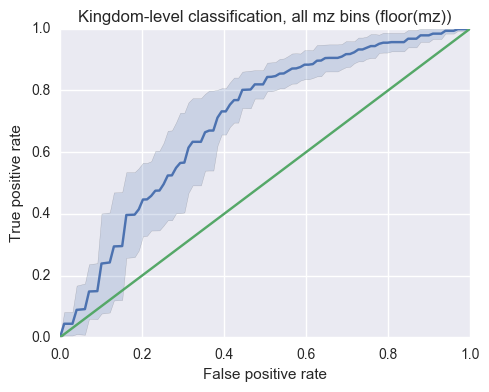

In [27]:
# Plot ROC curve
plt.figure(figsize=(5,4))
plt.plot(mean_fpr, mean_tpr)
std_tpr = np.std(tpr_lst, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Kingdom-level classification, all mz bins (floor(mz))')
plt.plot([0, 1], [0, 1])
plt.tight_layout()

# Feature selection

Limit features to mz bins which were present in at least 50 molecules

In [18]:
n_mlcls = 50
print('{} mz bins are present in more than {} molecules'.format((binarypeaks.sum() > n_mlcls).sum(), n_mlcls))

278 mz bins are present in more than 50 molecules


In [19]:
binarypeaks_50 = binarypeaks.loc[:, binarypeaks.sum() > n_mlcls]

In [20]:
X_50, Y = make_XY(binarypeaks_50, dfpeaks)
rf = RandomForestClassifier(n_estimators=1000)
num_cv = 10

In [29]:
X_50.shape

(864, 278)

In [21]:
# Train classifier
d = cv_train(rf, X_50, Y, num_cv)

tpr_lst = d['tpr']
mean_fpr = d['mean_fpr']
conf_mat = d['conf_mat']

0
1
2
3
4
5
6
7
8
9


In [22]:
# Extract some summary metrics
mean_tpr = np.mean(tpr_lst, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)
print(roc_auc)

# Get fisher p value, sensitivity/specificity, positive/negative pred value
_, fisher_p = fisher_exact(conf_mat)
# conf_mat: rows are the true labels, columns are the predicted labels
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = ['pred 0', 'pred 1']
conf_mat.index = ['true 0', 'true 1']

0.693759404747


In [32]:
# Confusion matrix shows classifier predictions on test set in all folds
conf_mat

,pred 0,pred 1
true 0,137,179
true 1,74,474


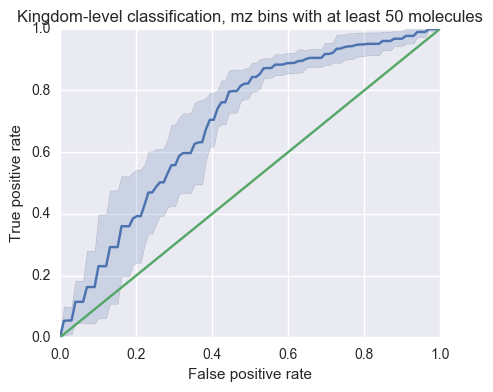

In [33]:
# Plot ROC curve
plt.figure(figsize=(5,4))
plt.plot(mean_fpr, mean_tpr)
std_tpr = np.std(tpr_lst, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Kingdom-level classification, mz bins with at least 50 molecules')
plt.plot([0, 1], [0, 1])
plt.tight_layout()

Hm, looks like our classifier is fairly good at getting class 1 (Chemical entities, N = 548) but performs basically randomly on class 0 (Organic compounds, N = 316). This might be due to class imbalance - need to look into different parameters we can change to adjust for this.

## Try balancing classes

In [36]:
rf = RandomForestClassifier(n_estimators=1000, class_weight="balanced_subsample")
num_cv = 10

d50_bal = cv_train(rf, X_50, Y, num_cv)

0
1
2
3
4
5
6
7
8
9


,pred 0,pred 1
true 0,129,187
true 1,66,482


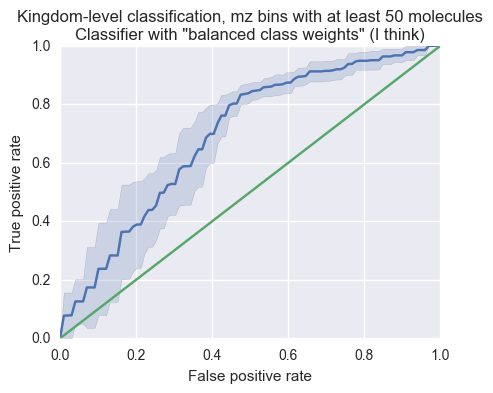

In [37]:
tpr_lst = d50_bal['tpr']
mean_fpr = d50_bal['mean_fpr']
conf_mat = d50_bal['conf_mat']

# Extract some summary metrics
mean_tpr = np.mean(tpr_lst, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

# Get fisher p value, sensitivity/specificity, positive/negative pred value
_, fisher_p = fisher_exact(conf_mat)
# conf_mat: rows are the true labels, columns are the predicted labels
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = ['pred 0', 'pred 1']
conf_mat.index = ['true 0', 'true 1']

# Confusion matrix shows classifier predictions on test set in all folds
display(conf_mat)

# Plot ROC curve
plt.figure(figsize=(5,4))
plt.plot(mean_fpr, mean_tpr)
std_tpr = np.std(tpr_lst, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Kingdom-level classification, mz bins with at least 50 molecules\nClassifier with "balanced class weights" (I think)')

plt.plot([0, 1], [0, 1])
plt.tight_layout()

It doesn't look like balancing classes did anything...?

# Classify class of interest below kingdom-level

Maybe the reason the classifier isn't working is that we're combining too many disparate things into our classifier.

Which makes me think: we should do some dimensionality reduction and clustering and see how well molecule classes cluster together...

In [39]:
display(dfpeaks[['inchi', 'hmdb', 'super_class']].drop_duplicates().groupby('super_class').size().sort_values(ascending=False))

super_class
Organic compounds                          539
Lipids and lipid-like molecules             90
Organic acids and derivatives               55
Organoheterocyclic compounds                45
Organic oxygen compounds                    43
Benzenoids                                  41
Phenylpropanoids and polyketides            16
Organic nitrogen compounds                  14
Inorganic compounds                          9
Nucleosides, nucleotides, and analogues      6
Organosulfur compounds                       5
Hydrocarbons                                 1
dtype: int64

In [40]:
display(dfpeaks[['inchi', 'hmdb', 'cls']].drop_duplicates().groupby('cls').size().sort_values(ascending=False).head(20))

cls
Organic acids and derivatives;              170
Lipids and lipid-like molecules;             95
Organoheterocyclic compounds;                71
Organic oxygen compounds;                    63
Benzenoids;                                  51
Nucleosides, nucleotides, and analogues;     47
Steroids and steroid derivatives;            45
Carboxylic acids and derivatives;            43
Organooxygen compounds;                      43
Fatty Acyls;                                 30
Benzene and substituted derivatives;         28
Phenylpropanoids and polyketides;            22
Organic nitrogen compounds;                  16
Organonitrogen compounds;                    14
Prenol lipids;                               13
Pyridines and derivatives;                   10
Phenols;                                     10
Homogeneous non-metal compounds;              9
Imidazopyrimidines;                           6
Indoles and derivatives;                      6
dtype: int64

## Classify class level

Let's only look at classes with >= 40 molecules.

In [32]:
# Check how many of each class we have (kingdom-level)
XandY = pd.merge(binarypeaks, dfpeaks[['inchi', 'cls']].drop_duplicates(),
                 left_index=True, right_on='inchi',
                 how='left')

In [33]:
clscounts = (XandY.groupby('cls').size()).reset_index()
clscounts.columns = ['cls', 'n_mlcls']
clscounts.query('n_mlcls >= 40')

,cls,n_mlcls
4,Benzenoids;,51
6,Carboxylic acids and derivatives;,43
24,Lipids and lipid-like molecules;,95
26,"Nucleosides, nucleotides, and analogues;",47
27,Organic acids and derivatives;,170
30,Organic oxygen compounds;,63
33,Organoheterocyclic compounds;,71
35,Organooxygen compounds;,43
52,Steroids and steroid derivatives;,45


In [34]:
classes = clscounts.query('n_mlcls >=40')['cls'].tolist()
dfpeaks_cls40 = dfpeaks.query('cls == @classes')

In [35]:
dfpeaks_cls40.head()

,inchi,hmdb,kingdom,super_class,sub_class,cls,molecular_framework,ms2_scan,num_peaks,mz,intensity,ion_mode,rounded_mz
1515,CCLQKVKJOGVQLU-QMMMGPOBSA-N,HMDB0000745,Chemical entities,Organic compounds,Peptidomimetics,Organic acids and derivatives;,Aromatic heteromonocyclic compounds,0,7,86.073,5.294,Positive,86
1516,CCLQKVKJOGVQLU-QMMMGPOBSA-N,HMDB0000745,Chemical entities,Organic compounds,Peptidomimetics,Organic acids and derivatives;,Aromatic heteromonocyclic compounds,0,7,95.090,2.083,Positive,95
1517,CCLQKVKJOGVQLU-QMMMGPOBSA-N,HMDB0000745,Chemical entities,Organic compounds,Peptidomimetics,Organic acids and derivatives;,Aromatic heteromonocyclic compounds,0,7,110.056,20.588,Positive,110
1518,CCLQKVKJOGVQLU-QMMMGPOBSA-N,HMDB0000745,Chemical entities,Organic compounds,Peptidomimetics,Organic acids and derivatives;,Aromatic heteromonocyclic compounds,0,7,155.966,100.000,Positive,155
1519,CCLQKVKJOGVQLU-QMMMGPOBSA-N,HMDB0000745,Chemical entities,Organic compounds,Peptidomimetics,Organic acids and derivatives;,Aromatic heteromonocyclic compounds,0,7,223.043,9.412,Positive,223


In [36]:
def cv_train_multiclass(rf, X, Y, num_cv, random_state=12345):

    cv = StratifiedKFold(Y, num_cv, shuffle=True, random_state=random_state)

    tpr_lst = []
    mean_fpr = np.linspace(0, 1, 100)
    conf_mat = np.zeros((len(set(Y)), len(set(Y))))
    y_probs = np.empty_like(Y)
    y_predictions = np.empty_like(Y)

    n = 0
    for train_index, test_index in cv:
        print(n)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        probs = rf.fit(X_train, Y_train).predict_proba(X_test)[:,1]
        preds = rf.predict(X_test)

        # Store probability and predicted values for X_test
        y_probs[test_index] = probs
        y_predictions[test_index] = preds

        # Compute confusion matrix
        conf_mat += confusion_matrix(Y_test, preds)

        n += 1
    return dict(zip(['conf_mat', 'y_probs', 'y_preds'],
                    [conf_mat, y_probs, y_predictions]))

In [37]:
inchi_keep = dfpeaks_cls40['inchi'].unique()
binarypeaks_cls40 = binarypeaks.loc[inchi_keep]
dfpeaks_cls40.index = dfpeaks_cls40['inchi']

X = binarypeaks_cls40.values
Y = dfpeaks_cls40[['inchi', 'cls']].drop_duplicates().loc[inchi_keep, 'cls'].values

In [38]:
# Prep for classification
rf = RandomForestClassifier(n_estimators=1000)
num_cv = 10

In [39]:
print(X.shape, Y.shape)

((628, 1531), (628,))


In [40]:
set(Y)

{'Benzenoids;',
 'Carboxylic acids and derivatives;',
 'Lipids and lipid-like molecules;',
 'Nucleosides, nucleotides, and analogues;',
 'Organic acids and derivatives;',
 'Organic oxygen compounds;',
 'Organoheterocyclic compounds;',
 'Organooxygen compounds;',
 'Steroids and steroid derivatives;'}

In [41]:
rf = RandomForestClassifier(n_estimators=1000, class_weight="balanced_subsample")
num_cv = 5

In [42]:
dcls40 = cv_train_multiclass(rf, X, Y, num_cv)

0
1
2
3
4


In [43]:
conf_mat = dcls40['conf_mat']
conf_mat = pd.DataFrame(conf_mat, index=['true_' + i for i in sorted(set(Y))],
                       columns=['pred_' + i for i in sorted(set(Y))])

This table below is the normalized confusion matrix showing the performance on class-level classification.

In [44]:
# Normalize confusion matrix by number of elements in each true class
conf_mat.divide(conf_mat.sum(axis=1), axis=0)

,pred_Benzenoids;,pred_Carboxylic acids and derivatives;,pred_Lipids and lipid-like molecules;,"pred_Nucleosides, nucleotides, and analogues;",pred_Organic acids and derivatives;,pred_Organic oxygen compounds;,pred_Organoheterocyclic compounds;,pred_Organooxygen compounds;,pred_Steroids and steroid derivatives;
true_Benzenoids;,0.509804,0.000000,0.019608,0.019608,0.352941,0.000000,0.098039,0.000000,0.000000
true_Carboxylic acids and derivatives;,0.046512,0.139535,0.023256,0.046512,0.674419,0.000000,0.000000,0.069767,0.000000
true_Lipids and lipid-like molecules;,0.042105,0.000000,0.294737,0.000000,0.536842,0.010526,0.021053,0.031579,0.063158
"true_Nucleosides, nucleotides, and analogues;",0.000000,0.021277,0.042553,0.425532,0.468085,0.021277,0.000000,0.000000,0.021277
true_Organic acids and derivatives;,0.041176,0.005882,0.035294,0.011765,0.847059,0.005882,0.017647,0.023529,0.011765
true_Organic oxygen compounds;,0.031746,0.000000,0.031746,0.015873,0.555556,0.190476,0.015873,0.126984,0.031746
true_Organoheterocyclic compounds;,0.028169,0.000000,0.070423,0.014085,0.394366,0.014085,0.450704,0.028169,0.000000
true_Organooxygen compounds;,0.000000,0.000000,0.023256,0.000000,0.372093,0.186047,0.000000,0.418605,0.000000
true_Steroids and steroid derivatives;,0.000000,0.000000,0.066667,0.066667,0.200000,0.000000,0.000000,0.000000,0.666667


In [47]:
# Normalize confusion matrix by number of elements in each true class
conf_mat.divide(conf_mat.sum(axis=1), axis=0).to_csv('class_classifier_confmat.csv')

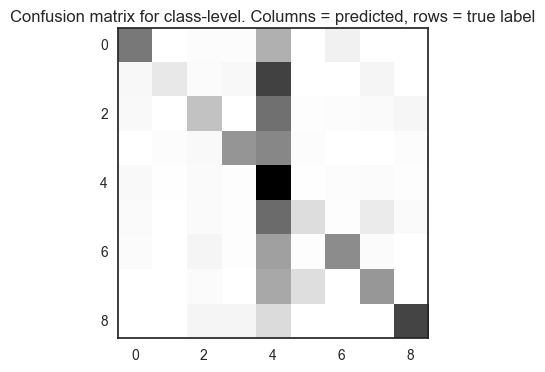

In [45]:
sns.set_style('white')
plt.imshow(conf_mat.divide(conf_mat.sum(axis=1), axis=0), interpolation='nearest')
plt.title("Confusion matrix for class-level. Columns = predicted, rows = true label")

In [46]:
print('These are the order of labels in rows and columns')
print('\n'.join([str(i) + ': ' + conf_mat.columns[i].split('_')[1] for i in range(len(conf_mat.columns))]))

These are the order of labels in rows and columns
0: Benzenoids;
1: Carboxylic acids and derivatives;
2: Lipids and lipid-like molecules;
3: Nucleosides, nucleotides, and analogues;
4: Organic acids and derivatives;
5: Organic oxygen compounds;
6: Organoheterocyclic compounds;
7: Organooxygen compounds;
8: Steroids and steroid derivatives;


Ooooo looks like high specificity for steroids!

Also looks like predicting "organic acids and derivatives" is fairly meaningless - perhaps this is another example of a classification that is too variable to have generalizable signal for the classifier to pull out.

Interestingly, there aren't any particular patterns about specific classes being consistently misclassified as other things.

Well, maybe there's a bit of confusion between organooxygen compounds and organic oxygen compounds, which sounds fairly understandable. I wonder if these are two words for the same thing...?

# To do

- dealing with multiple MS2s   
    - do all of these same classifiers without merging MS2s (i.e. each individual scan is one observation, rather than combining scans from same molecule into one observation)      
    - make sure signals are not confounded with positive/negative mode   
    - Julian mentioned that HMDB's predicted MS2s are actually pretty good, and in many cases better than the experimental ones. Do we have the predicted MS2's? Can we do our analyses just on this subset?   
- feature engineering
    - different sized mz bins? (how large can we make the bins without breaking classifier?)    
    - data-driven bin definitions (i.e. quantile-based definition. here also: how large can we make the bings without breaking classifier?)   
    - different thresholds for bin selection? (i.e. bin is present in at least N molecules)   
    - MS2LDA!!!   
- classification problem / labeling    
    - multi-class classification vs. one vs all (do these give us different answers and interpretations? what is the more useful problem?)    
    - check the taxonomy labels:
        - are they hierarchical? i.e. are all lipid sub-classes in the same super class, or are any labels polyphyletic?    
        - are they consistent? i.e. are there different names for the same thing, especially in the low-count labels? 
    - repeat analysis for all chemical taxonomy levels    
- data quality    
    - how much additional info is in MassBank?    
    - can we just scrape the HMDB website directly? seems like web pages have (1) more frequently filled-out taxonomy hierarchiers than in the xmls and (2) direct links to the predicted LC-MS/MS (which may not be present in our data?)    